In [18]:
from datasets import load_from_disk, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch, pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

def infer(model_dir, test_path):
    ds = load_from_disk(test_path)["sanity"]      # HFD Dataset
    tokenizer = AutoTokenizer.from_pretrained(model_dir)
    device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model    = AutoModelForSequenceClassification.from_pretrained(model_dir).to(device).eval()

    
    def _pred(batch):
        toks = tokenizer(batch["text"], padding=True, truncation=True, return_tensors="pt")
        with torch.no_grad():
            toks = tokenizer(batch["text"], padding=True, truncation=True, return_tensors="pt").to(device)
            logits = model(**toks).logits
        return {"pred": logits.argmax(-1)}

    preds = ds.map(_pred, batched=True, batch_size=32)
    return preds

base  = infer("/home/ubuntu/SentiSynth/runs/student/real_1k/", "/home/ubuntu/SentiSynth/data/real_1k")
aug20 = infer("/home/ubuntu/SentiSynth/runs/student/mix_20k_real_1k/", "/home/ubuntu/SentiSynth/data/mix_20k_real_1k")


Map:   0%|          | 0/3368 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/3368 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [19]:
from sklearn.metrics import classification_report
print(classification_report(
        y_true=list(base["labels"]),
        y_pred=list(base["pred"]),
        digits=3))

              precision    recall  f1-score   support

           0      0.744     0.737     0.740      1496
           1      0.791     0.797     0.794      1872

    accuracy                          0.770      3368
   macro avg      0.767     0.767     0.767      3368
weighted avg      0.770     0.770     0.770      3368



In [20]:
import numpy as np, re, seaborn as sns, matplotlib.pyplot as plt
neg_regex = re.compile(r"\b(not|n't|never|no)\b", flags=re.I)

def add_attrs(ds: Dataset):
    ds = ds.add_column("len",   [len(t.split()) for t in ds["text"]])
    ds = ds.add_column("neg",   [bool(neg_regex.search(t)) for t in ds["text"]])
    return ds
base  = add_attrs(base)
aug20 = add_attrs(aug20)

def rate(ds, cond):
    mask = ds.filter(cond)
    report = classification_report(mask["labels"], mask["pred"],output_dict=True)
    return report["accuracy"]

for label, cond in {
        "≤10 tokens":  lambda ex: ex["len"] <= 10,
        "11‑20 tokens":lambda ex: 10 < ex["len"] <= 20,
        "negation":    lambda ex: ex["neg"],
        "no‑negation": lambda ex: not ex["neg"]
    }.items():
    print(f"{label:15s} | base={rate(base,cond):.3f}  →  aug20={rate(aug20,cond):.3f}")


Filter:   0%|          | 0/3368 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3368 [00:00<?, ? examples/s]

≤10 tokens      | base=0.785  →  aug20=0.828


Filter:   0%|          | 0/3368 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3368 [00:00<?, ? examples/s]

11‑20 tokens    | base=0.741  →  aug20=0.782


Filter:   0%|          | 0/3368 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3368 [00:00<?, ? examples/s]

negation        | base=0.682  →  aug20=0.740


Filter:   0%|          | 0/3368 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3368 [00:00<?, ? examples/s]

no‑negation     | base=0.778  →  aug20=0.822


In [ ]:
err = aug20.filter(lambda ex: ex["pred"]!=ex["labels"]).select(range(20))
errdf = pd.DataFrame({
    "text": [t for t in err["text"]],
    "true": err["labels"],
    "pred": err["pred"]
})
display(errdf)
errdf.to_csv("~/SentiSynth/notebooks/error_analysis.csv", index=False, encoding="utf‑8")


,text,true,pred
0,covered earlier and much better,0,1
1,what does n't this film have that an impressio...,1,0
2,the campy results make mel brooks ' borscht be...,1,0
3,than indecent proposal,1,0
4,the mystery of enigma is how a rich historical...,0,1
5,that flow through the hollywood pipeline witho...,1,0
6,is too bad that this likable movie is n't more...,1,0
7,joyless,0,1
8,ready-made midnight movie,1,0
9,"a third-person story now , told by hollywood ,...",0,1


In [22]:
import glob, json, collections, math

def load_jsonl(path):
    with open(path) as f:
        return [json.loads(line) for line in f]

synth_07 = load_jsonl("/home/ubuntu/SentiSynth/data/synthetic_sst2_tau_0.7/train.jsonl")
synth_08 = load_jsonl("/home/ubuntu/SentiSynth/data/synthetic_sst2_tau_0.8/train.jsonl")
synth_09 = load_jsonl("/home/ubuntu/SentiSynth/data/synthetic_sst2_tau_0.9/train.jsonl")


In [23]:
def distinct_n(samples, n):
    total_tokens, unique_ngrams = 0, set()
    for s in samples:
        toks = s.lower().split()
        total_tokens += len(toks)
        for i in range(len(toks)-n+1):
            unique_ngrams.add(tuple(toks[i:i+n]))
    return len(unique_ngrams)/max(1,total_tokens)

def avg_entropy(dataset):
    ent = []
    for row in dataset:
        p_neg, p_pos = row["soft_labels"]
        e = -sum(p*math.log(p+1e-12) for p in (p_neg, p_pos))
        ent.append(e)
    return sum(ent)/len(ent)


In [27]:
rows = []
for name, ds in [("0.7", synth_07), ("0.8", synth_08), ("0.9", synth_09)]:
    rows.append({
        "tau": float(name),
        "Distinct-1": distinct_n([r["text"] for r in ds], 1),
        "Distinct-2": distinct_n([r["text"] for r in ds], 2),
        "Entropy":    avg_entropy(ds),
    })

import pandas as pd
df = pd.DataFrame(rows)
display(df)


,tau,Distinct-1,Distinct-2,Entropy
0,0.7,0.022382,0.262025,0.681052
1,0.8,0.024106,0.268781,0.675690
2,0.9,0.026319,0.277667,0.668949


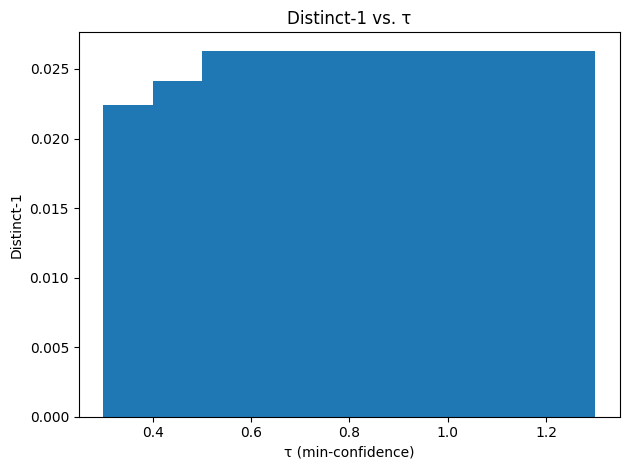

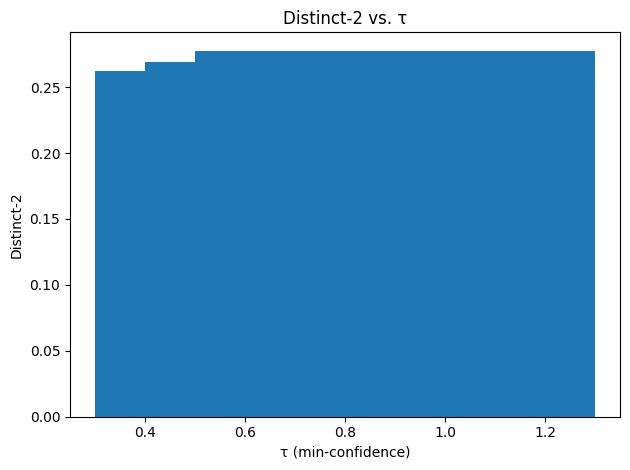

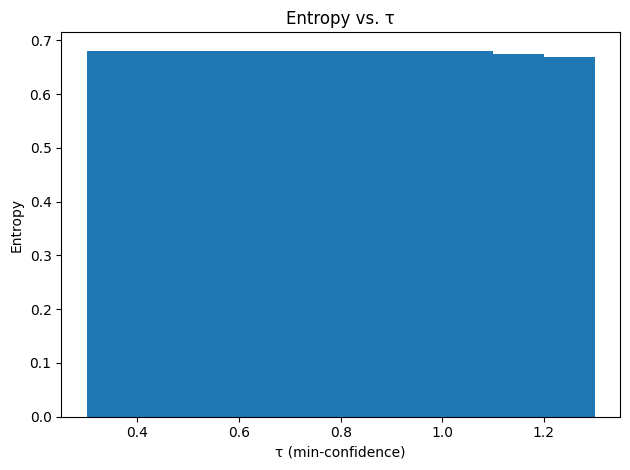

In [29]:
import matplotlib.pyplot as plt
metrics = ["Distinct-1", "Distinct-2", "Entropy"]
x = df["tau"]

for metric in metrics:
    plt.figure()
    plt.bar(x, df[metric])
    plt.xlabel("τ (min‑confidence)")
    plt.ylabel(metric)
    plt.title(f"{metric} vs. τ")
    plt.tight_layout()
    plt.savefig(f"/home/ubuntu/SentiSynth/notebooks{metric.lower()}_vs_tau.png")

